# Workshop 3: Features

In Lecture 6 we talked about feature extraction. In this workshop we will put in practice some of the methods we have learned in the lecture.

## Learning objectives

At the end of this workshop you will be able to:

- Extract blob-like features from images and compare different algorithms
- Use the Hough transform to detect lines and circles in images
- Use the SIFT and SURF features to detect and match objects in images (we haven't covered these in the lecture but they are very useful, so I will cover them here)

## Blob detection

Let's start by looking at blob detection. We will use the [`skimage.feature.blob_log`](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log) function to detect blobs in an image. As we saw in the lecture, this function uses the Laplacian of Gaussian (LoG) to detect blobs.

Let's start by opening and displaying the `retina.jpg` image [Credits: [Librepath - Own work, CC BY-SA 3.0](https://commons.wikimedia.org/w/index.php?curid=45308378)]. This is an haematoxylin and eosin (H&E) stained image of a retina. Haematoxylin stains nuclei in a dark purple colour; eosin stains the extracellular matrix and the cytoplasm in pink.

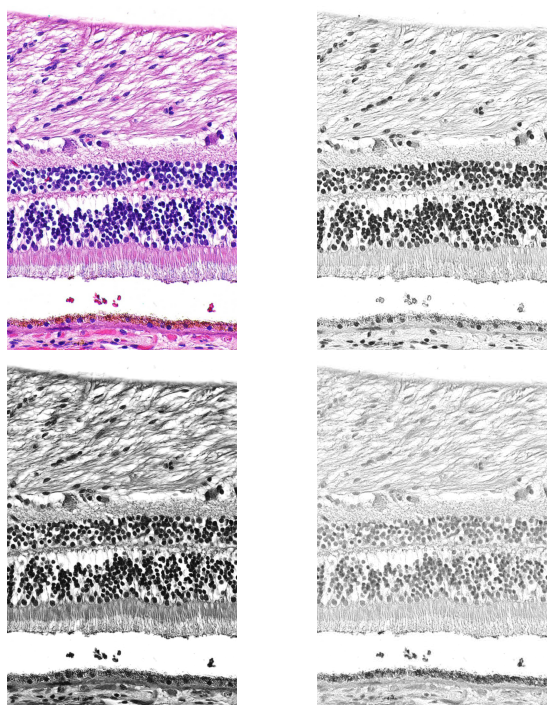

In [2]:
# Read the image and plot it
import matplotlib.pyplot as plt
from skimage.io import imread

img = imread("retina.jpg")

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(img)
ax[0,1].imshow(img[:,:,0], cmap="gray")
ax[1,0].imshow(img[:,:,1], cmap="gray")
ax[1,1].imshow(img[:,:,2], cmap="gray")

for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

We are now interested in counting how many nuclei are in this image. Since nuclei look like dark, uniform blobs on a light background, we can use the LoG to detect blobs.

First of all, however, we need to do some preprocessing.
The `blob_log` function works on both 2D and 3D images. This is a RGB image, and we need to convert it to a grayscale image, otherwise `blob_log` will think we are passing a 3D image and will give us some strange results.

Furthermore, the function expects bright spots on a dark background, so we need to invert the image.

So let's do that!

1. Convert the image to grayscale
2. Invert the image
3. Display the images to check everything is working as expected!

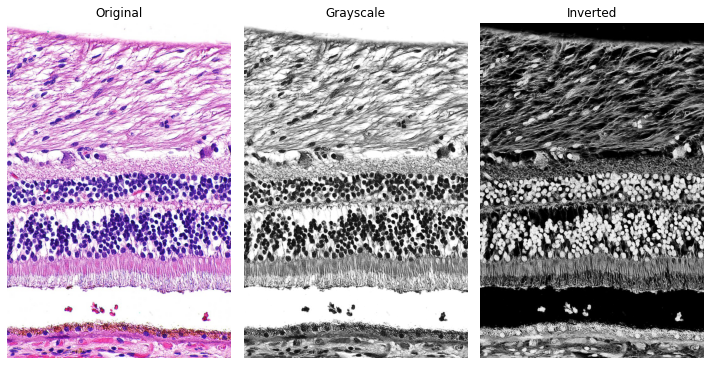

In [3]:
from skimage.color import rgb2gray

# You can either use rgb2gray or pick a color channel. 
# It might be useful to look at individual channels and see if
# nuclei are more evident in a specific one
img_gray = img[:,:,1]
img_inverted = 255 - img_gray 

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(img, cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(img_gray, cmap="gray")
ax[1].set_title("Grayscale")
ax[2].imshow(img_inverted, cmap="gray")
ax[2].set_title("Inverted")

for a in ax:
    a.axis("off")

plt.tight_layout()

Now we can finally apply the `blob_log` function to the inverted image.

Remember that the `blob_log` function takes the following arguments:
    
- `image`: The image to detect blobs in
- `min_sigma`: The minimum standard deviation for the LoG filter
- `max_sigma`: The maximum standard deviation for the LoG filter
- `num_sigma`: The number of standard deviations to consider
- `threshold`: The absolute lower bound for maxima to be considered as blobs

How do we chose these parameters? You can start with some reasonable values and experiment with them. For example, try and manually check the radius of a nucleus, and use values of $\sigma$ that are in that order of magnitude. Remember that the radius of the blob is $\sqrt{2}\sigma$ so if you use $\sigma=10$ you will detect blobs of radius ~14.

_Note_: you might want to keep down the `num_sigma` parameter (say 5 or 10), at least while tuning the rest, as it will take a long time to run otherwise.

We need to check the output of the `blob_log` function. We could print it out, but that would be hard to interpret. Instead, we will plot circles over the image to show the detected blobs.

Let's start by estimating the size of a nucleus

14.14213562373095


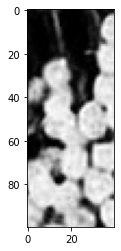

In [4]:
from math import sqrt
# Estimate the size of a nucleus
# Let's show a crop of the image to zoom in on the nuclei and visually estimate their size
plt.imshow(img_inverted[600:700, 300:340], cmap="gray")

# It looks like the average nucleus is ~20 pixels wide, so 10 pixels of radius
# Since radius = sqrt(2) * sigma, sigma = radius / sqrt(2)
print(20 / sqrt(2))

Now let's apply the `blob_log` function to the image.

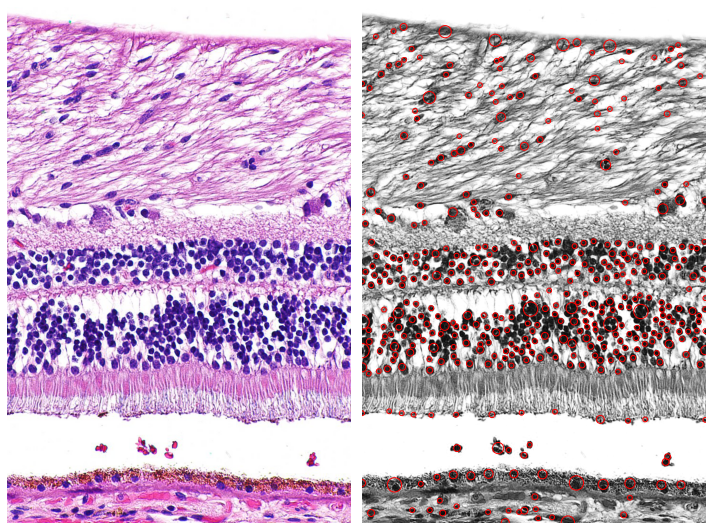

In [13]:
from skimage.feature import blob_log

# Remember to use the inverted image!
blobs = blob_log(img_inverted, overlap=0.4, min_sigma=5, max_sigma=15, num_sigma=10, threshold=.23)

# Display the image
fig, ax = plt.subplots(1, 2, figsize=(10, 15))
ax[0].imshow(img)
ax[1].imshow(img_gray, cmap="gray")
# Overlay the blobs on the image. Remember that the centers of the blobs are returned in
# (y, x) order. The third dimension of the blobs array is sigma

for b in blobs:
    y, x, r = b
    c = plt.Circle((x, y), r, color="red", linewidth=1, fill=False)
    ax[1].add_patch(c)

for a in ax:
    a.axis("off")

plt.tight_layout()


That is not too bad! 
**What are the parts where this approach does not work well? Why do you think this is the case?**

The worst results are where a lot of nuclei are clumped together. This is because the nuclei don't really look like blobs anymore there! They are still uniform in intensity/texture, but they do not have a clearly distinct background around it, which is what the LoG detects when you convolve it with the image.

You can try optimising the results by manipulating the input image, e.g. by changing the way you convert it to grayscale, or by manipulating its histogram.
Obviously, also changing the parameters of the `blob_log` function can help improve the results!

**How did it go for you? Post your results on Slack!**

**Can you think of a way to quantitatively evaluate how good different solutions are?**

### Saving results to file

Now it'is probably a good time to save our results to file, so that we can use the data further down the line.

Although we could use Python base I/O functions to read/write files (see the [Python documentation](https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files) on how to do that), when dealing with tabular data, the `pandas` library is super helpful!

If you have not already, you should install `pandas` (e.g. through `pip install pandas`). There are some super-useful tutorials on how to use `pandas` [on their website](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html), but essentially for this workshop we will be:

- Importing `pandas` (commonly imported as `pd`)
- Converting our results in a `DataFrame` class
- Using the `to_csv` method to save to a CSV file.

In [17]:
import pandas as pd

# We convert the results from blob_log to a pandas DataFrame
# We can specify column names to make things prettier :)
blobs_df = pd.DataFrame(data = blobs, columns=["Center_Y", "Center_X", "Sigma"])

# Let's see what we have
print(blobs_df)

# Now, save to file. We can use index=False to avoid printing the index (the row number)
blobs_df.to_csv("blobs.csv", index = False)

     Center_Y  Center_X      Sigma
0       923.0     199.0   7.222222
1       916.0     351.0   5.000000
2       952.0     636.0   7.222222
3       927.0     307.0   5.000000
4       720.0      37.0   5.000000
..        ...       ...        ...
430    1027.0     561.0   5.000000
431     590.0     685.0   5.000000
432     500.0     445.0   5.000000
433      69.0     279.0  12.777778
434     423.0     234.0   5.000000

[435 rows x 3 columns]


Et voilà, you now have a CSV output of your analysis! You could read this file for further analysis, for example you could calculate the density of nuclei depending on the layer of the retina where you are in, or look at the average distance between nuclei, or whether there is a relationship between radius and position etc!

## Counting cells

In this exercise we are now going to create a few functions to estimate cell density given a photo of a haemocytometer, just like we saw in the lecture. If you want to know more about how an haemocytometer works please see the [Wikipedia page](https://en.wikipedia.org/wiki/Hemocytometer).

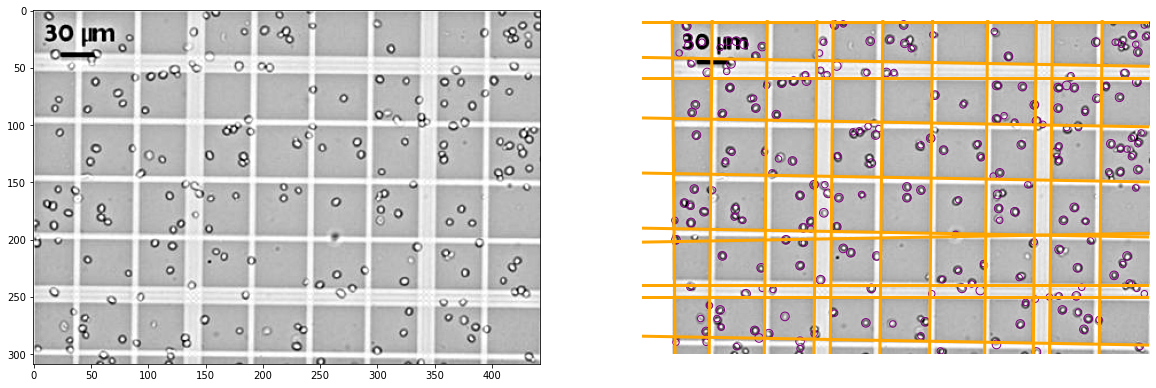

In [54]:
# Import required libraries
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks
from skimage.feature import canny
import numpy as np
import matplotlib.pyplot as plt

img = imread("yeast_count.jpg")
# Convert to grayscale and detect edges using Canny
img = rgb2gray(img)
# Unsharp mask the image to remove noise
img = unsharp_mask(img, radius=5, amount=1)
img_canny = canny(img)

# Use the linear Hough transform to detect the lines in the image
hough_space, angles, d = hough_line(img_canny)
line_accum, theta, rho = hough_line_peaks(hough_space, angles, d, threshold=120)

# Uses the circular Hough transform to detect cells in the image
# Cells are pretty small, we can try radii of 3-5 pixels
radii = range(3, 5)
cells = hough_circle(img_canny, radii)
circle_accum, cx, cy, radii = hough_circle_peaks(cells, radii, min_xdistance=5, min_ydistance=5, threshold = .55)

# Now show the image with the lines and circles overlayed
fig, ax = plt.subplots(1, 2, figsize =(20, 10))
ax[0].imshow(img, cmap="gray")
ax[1].imshow(img, cmap="gray")
ax[1].axis("off")

# Draw lines
for angle, dist in zip(theta, rho):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi/2), linewidth=3, color='orange')

# Draw circles
for c_x, c_y, r in zip(cx, cy, radii):
    c = plt.Circle((c_x, c_y), r, color='purple', linewidth=1, fill=False)
    ax[1].add_artist(c)

plt.show()

**How many cells were detected?**

In [55]:
# Count cells. We just look at how many circles we've got!
print(f"{len(cx)} cells detected.")

216 cells detected.


**Is there any issue with counting cells this way?**

Yes, the scale bar on the top-left is a problem, also we should really be looking at a single square, since we know its volume, to properly calculate cell concentration. 

**Bonus exercises**: 
1. Can you come up with a way of quantifying the number of cells in the central "macro-square" (the one with 16 smaller squares in it that is defined by the larger lines)?
2. Can you tidy up the code and convert it into a class?

**Problem 1**

One idea is to look at the distance between horizontal and vertical lines. The small lines should be equally spaced, while the thick border should be made up by close-by lines.

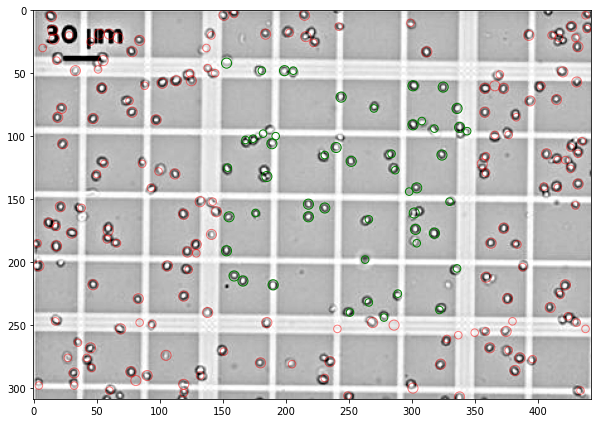

In [66]:
# Find the horizontal lines (the ones with angle ~0)
# Note that sometimes the angle is slightly off, so we'll use a tolerance of 0.1 radians
hor_rho = abs(rho[abs(theta) < 0.1])
# Sort the lines and find the distance from the previous one
hor_rho.sort()

hor_thick = []
for i, pos in enumerate(hor_rho[:-1]):
    distance = hor_rho[i+1] - pos
    # print(f"Distance between lines {i} and {i+1}: {hor_rho[i+1] - pos}")
    # This number (35) is hard-coded but you could calculate all distances 
    # and automatically decide your threshold
    if distance < 35: 
        hor_thick.append(hor_rho[i+1])

# Now do the same for vertical lines

# Find the horizontal lines (the ones with angle ~pi/2)
ver_rho = abs(rho[abs(theta) > np.pi/2 - 0.1])
# Sort the lines and find the distance from the previous one
ver_rho.sort()

ver_thick = []
for i, pos in enumerate(ver_rho[:-1]):
    distance = ver_rho[i+1] - pos
    #print(f"Distance between lines {i} and {i+1}: {ver_rho[i+1] - pos}")
    if distance < 20: 
        ver_thick.append(ver_rho[i])

# Plot the image with the cells overlayed. Use a different color 
# depending on the location of the cells
fig, ax = plt.subplots(1, 1, figsize =(10, 10))
ax.imshow(img, cmap="gray")
#ax.axis("off")

for c_x, c_y, r in zip(cx, cy, radii):
    if min(hor_thick) < c_x < max(hor_thick) and min(ver_thick) < c_y < max(ver_thick):
        c = plt.Circle((c_x, c_y), r, color='green', linewidth=1, fill=False)
    else:
        c = plt.Circle((c_x, c_y), r, color='red', linewidth=1, fill=False, alpha=0.5)
    ax.add_artist(c)

**Problem 2**

Here is an example of a class that can be used to detect/count cells in an image (this does not consider the central square only, but  you can try to implement that!).

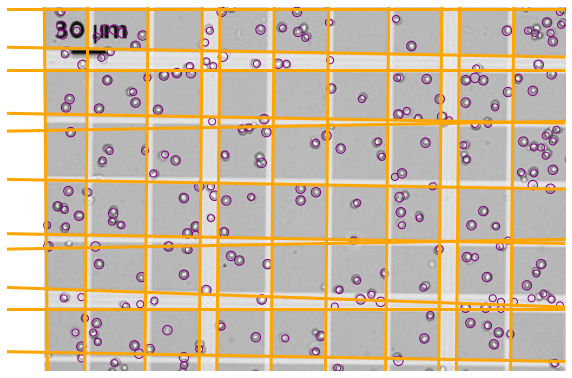

In [75]:
# Import required libraries
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks
from skimage.feature import canny
import numpy as np
import matplotlib.pyplot as plt

class Haemocytometer:
    """
    Estimate cell counts in a haemocytometer, starting from an input image.
    This class uses the linear Hough transform to identify the haemocytometer squares,
    then the circle Hough transform to count cells in the haemocytometer.
    """

    def __init__(self, image_file, avg_cell_radius=4, cell_threshold=0.55, cell_min_xdistance=5, cell_min_ydistance=5):
        """ The class constructor

        Args:
            image_file (str): The filename of the haemocytometer image
        """
        self.img = imread(image_file)
        # If we have a RGB image convert it to grayscale
        if len(self.img.shape) == 3:
           self.img = rgb2gray(self.img)
        # Unsharp mask the image to remove noise
        # Since we really do not need this anymore we are not going to store it in the class
        img_sharpened = unsharp_mask(self.img, radius=avg_cell_radius*2, amount=1)
        self.canny = canny(img_sharpened)

        self.avg_cell_radius = avg_cell_radius
        self.cell_threshold = cell_threshold
        self.cell_min_xdistance = cell_min_xdistance
        self.cell_min_ydistance = cell_min_ydistance

        # The lines and cells that we detected
        self.lines = None
        self.cells = None

    def show_img(self):
        """ 
        Show the image
        """
        fig, ax = plt.subplots(1, 1, figsize =(10, 10))
        ax.imshow(self.img, cmap="gray")
        ax.axis("off")
    
        if self.lines is not None: # We already called find_lines to detect lines
            # Draw lines
            for _, angle, dist in self.lines:
                (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
                ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), linewidth=3, color='orange')

        if self.cells is not None: # We already called find_cells to detect cells
            # Draw circles
            for c_x, c_y, r in self.cells:
                c = plt.Circle((c_x, c_y), r, color='purple', linewidth=1, fill=False)
                ax.add_artist(c)

        plt.show()

    def find_lines(self):
        """
        Uses the linear Hough transform to detect the lines in the image
        """
        hough_space, angles, d = hough_line(self.canny)                
        accum, theta, rho = hough_line_peaks(hough_space, angles, d, threshold=120)        
        self.lines = zip(accum, theta, rho)

    def find_cells(self):
        """
        Uses the circular Hough transform to detect cells in the image
        """        
        radii = range(self.avg_cell_radius - 1, self.avg_cell_radius + 1)
        self.cells = hough_circle(self.canny, radii)
        accums, cx, cy, radii = hough_circle_peaks(self.cells, radii, 
                                                min_xdistance=self.cell_min_xdistance, 
                                                min_ydistance=self.cell_min_xdistance, threshold = self.cell_threshold)
        self.cells = zip(cx, cy, radii)


# Initialize a class instance
hc = Haemocytometer("yeast_count.jpg")
# Find the lines
hc.find_lines()
hc.find_cells()
hc.show_img()